## Linear Regression approach

Using OpenAI embeddings of repository topic, description and README

Train test split: 9/2

Single-Classification Accuracy: 96.5%

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

# loading the dataset of OpenAI embeddings

dataset = pd.read_csv('../finished_dataset/openai_finished_df.csv')

#cleaning and engineering the dataset to be used for model training
#The next two lines ensures that all rows of the dataset have one and only one sector label

dataset = dataset[dataset['label'] != '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]']
dataset = dataset[dataset['label'] != '[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]']
dataset['label'] = dataset['label'].apply(literal_eval)
dataset['label'] = dataset['label'].apply(lambda x: np.argmax(x, axis=0))
dataset['embedding_readme'] = dataset['embedding_readme'].apply(literal_eval)
dataset['embedding_description'] = dataset['embedding_description'].apply(literal_eval)
dataset['embedding_topic'] = dataset['embedding_topic'].apply(literal_eval)

dataset['features'] = dataset.apply(lambda row: np.concatenate((
    row['embedding_readme'],
    row['embedding_description'],
    row['embedding_topic']
)), axis=1)
dataset = dataset.reset_index(drop=True)

print(f"There are {dataset.shape[0]} rows in the dataset.")

There are 1100 rows in the dataset.


In [2]:
dataset['label'].value_counts()

label
8     88
17    85
10    83
16    80
15    77
0     77
7     71
9     68
3     54
14    53
11    51
18    50
12    50
6     48
13    46
2     40
1     38
19    18
5     15
4      8
Name: count, dtype: int64

As we see above, all NAICS sectors are represented in our dataset. However, it is worth noting the large variation amongst the different sectors. The least represented sector only has 8 repositories while the most represented sector has 88 repositories.

Next, we randomly shuffle the 1100 size dataset and split them into a 900-size training set and a 200-size test set.

In [3]:
shuffled_dataset = dataset.sample(frac=1, random_state=42)
split_ratio = 9/11
split_index = int(len(shuffled_dataset)*split_ratio)
train_set = shuffled_dataset.iloc[:split_index]
test_set = shuffled_dataset.iloc[split_index:]
print(f"Training set size: {train_set.shape[0]}")
print(f"Test set size: {test_set.shape[0]}")

Training set size: 900
Test set size: 200


In [4]:
train_labels = train_set['label'].tolist()
test_labels = test_set['label'].tolist()
sector_label_to_num = {
    "11": 0,
    "21": 1,
    "22": 2,
    "23": 3,
    "31-33": 4,
    "42": 5,
    "44-45": 6,
    "48-49": 7,
    "51": 8,
    "52": 9,
    "53": 10,
    "54": 11,
    "55": 12,
    "56": 13,
    "61": 14,
    "62": 15,
    "71": 16,
    "72": 17,
    "81": 18,
    "92": 19
}

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Below is the linear regression model we are using. 

The model makes use of Ridge regression. The general idea behind it is building one linear regression model for each sector using the training set, and then passing any test data through all 20 models and choosing the sector which the "highest-scoring" model belongs to as the classification sector.

Since there are rather strong imbalances in sector representation in the training dataset, we resolve that issue by assigning "weights" to each sector such that the model will not be biased towards a few particular sectors in its classification simply because they appear more frequently.

In [6]:
def np_one_hot(ind, n_ways, default_val=0):
    ret = np.ones((ind.shape[0], n_ways)) * default_val
    ret[np.arange(ind.shape[0]), ind] = 1
    return ret

def LS(train_set, train_labels, test_set, test_C, intercept=False):
    alpha = 1 / test_C
    clf = Ridge(alpha=alpha, fit_intercept=intercept, solver="cholesky")

    uniq_labels, counts = np.unique(train_labels, return_counts=True)
    n_ways = uniq_labels.shape[0]

    weights = 1.0 / counts
    sample_weights = weights[train_labels]

    ys_one_hot = np_one_hot(train_labels, n_ways)
    clf.fit(train_set, ys_one_hot, sample_weights)
    pred = clf.predict(test_set)
    weight_matrix = clf.coef_
    bias = clf.intercept_
    pred = np.argmax(pred, axis=1)
    return pred, clf, weights/np.sum(weights), n_ways

In [7]:
#Combining readme, topic, and description embeddings to get 4608 features

X_data = np.stack(train_set['features'].values)
X_labels = np.array(train_labels)

Y_data = np.stack(test_set['features'].values)

test_C = 100

In [8]:
#fitting the model and applying it onto our test set
pred, clf, weights, n_ways = LS(X_data, X_labels, Y_data, test_C)

In [9]:
#evaluating the metrics of our model performance
accuracy = accuracy_score(test_labels, pred)
precision = precision_score(test_labels, pred, average="macro")
recall = recall_score(test_labels, pred, average="macro")
f1 = f1_score(test_labels, pred, average="macro")
print("For classification using linear regression:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

For classification using linear regression:
Accuracy: 0.965
Precision: 0.972
Recall: 0.941
F1 score: 0.950


From the above evaluation, we achieve a 96.5% single-sector classification accuracy. From further empirical testing, slightly varying the train/test split ratio to 80/20 or 75/25 etc, or shuffling the dataset in a different way, would result in some variation in model performance. But accuracy generally still sits above 90%. 

Now, let's visualize our features and model performance a bit more.

Text(0.5, 23.52222222222222, 'Predicted')

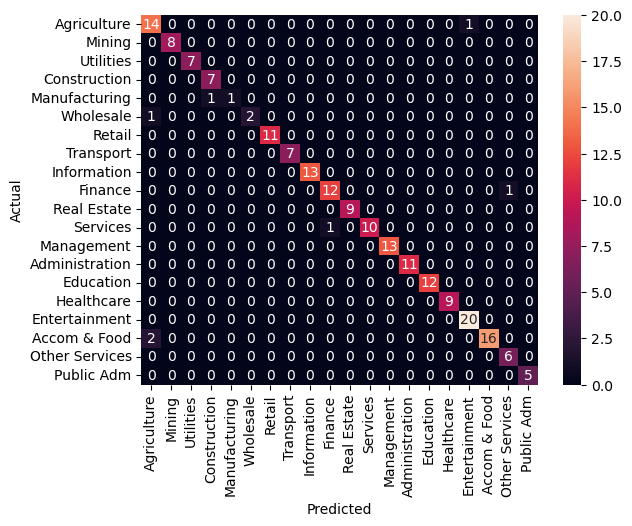

In [18]:
num_to_sector_name = {
    0: "Agriculture",
    1: "Mining",
    2: "Utilities",
    3: "Construction",
    4: "Manufacturing",
    5: "Wholesale",
    6: "Retail",
    7: "Transport",
    8: "Information",
    9: "Finance",
    10: "Real Estate",
    11: "Services",
    12: "Management",
    13: "Administration",
    14: "Education",
    15: "Healthcare",
    16: "Entertainment",
    17: "Accom & Food",
    18: "Other Services",
    19: "Public Adm"
}

true_test_labels_words = [num_to_sector_name[x] for x in test_labels]
pred_labels_words = [num_to_sector_name[x] for x in pred]
sector_names = list(num_to_sector_name.values())

plt.figure()
cf= confusion_matrix(true_test_labels_words, pred_labels_words, labels=sector_names)
cm_df = pd.DataFrame(cf, index=sector_names, columns=sector_names)
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

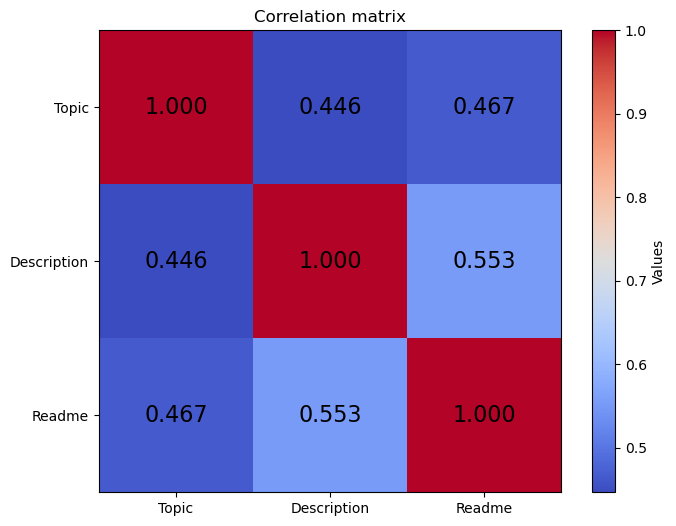

In [19]:
embeddings_set = dataset[['embedding_readme','embedding_description', 'embedding_topic']]

topic_corr = [embeddings_set['embedding_topic'].apply(lambda x: pd.Series(x)).corrwith(embeddings_set['embedding_topic'].apply(lambda x: pd.Series(x))).iloc[0], 
              embeddings_set['embedding_topic'].apply(lambda x: pd.Series(x)).corrwith(embeddings_set['embedding_description'].apply(lambda x: pd.Series(x))).iloc[0], 
              embeddings_set['embedding_topic'].apply(lambda x: pd.Series(x)).corrwith(embeddings_set['embedding_readme'].apply(lambda x: pd.Series(x))).iloc[0]]
desc_corr = [embeddings_set['embedding_description'].apply(lambda x: pd.Series(x)).corrwith(embeddings_set['embedding_topic'].apply(lambda x: pd.Series(x))).iloc[0], 
              embeddings_set['embedding_description'].apply(lambda x: pd.Series(x)).corrwith(embeddings_set['embedding_description'].apply(lambda x: pd.Series(x))).iloc[0], 
              embeddings_set['embedding_description'].apply(lambda x: pd.Series(x)).corrwith(embeddings_set['embedding_readme'].apply(lambda x: pd.Series(x))).iloc[0]]
readme_corr = [embeddings_set['embedding_readme'].apply(lambda x: pd.Series(x)).corrwith(embeddings_set['embedding_topic'].apply(lambda x: pd.Series(x))).iloc[0], 
              embeddings_set['embedding_readme'].apply(lambda x: pd.Series(x)).corrwith(embeddings_set['embedding_description'].apply(lambda x: pd.Series(x))).iloc[0], 
              embeddings_set['embedding_readme'].apply(lambda x: pd.Series(x)).corrwith(embeddings_set['embedding_readme'].apply(lambda x: pd.Series(x))).iloc[0]]

data = [
    topic_corr,
    desc_corr,
    readme_corr
]

# Plotting the heatmap manually with annotations
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(data, cmap='coolwarm', interpolation='nearest')

# Adding annotations (values) to the cells
for i in range(len(data)):
    for j in range(len(data[0])):
        plt.text(j, i, f'{data[i][j]:.3f}', ha='center', va='center', color='black', fontsize = 16)

# Adding colorbar
plt.colorbar(heatmap, label='Values')

# Setting labels for x and y axes
plt.xticks(ticks=range(len(data[0])), labels=['Topic', 'Description', 'Readme'])  # Replace labels with your own
plt.yticks(ticks=range(len(data)), labels=['Topic', 'Description', 'Readme'])    # Replace labels with your own

# Displaying the plot
plt.title('Correlation matrix')
plt.show()

The confusion matrix plotted earlier shows a very strong "diagonal" performance of our model. The above confusion matrix shows a moderately high degree of correlation between the embedding features, which is not surprising since the README, description and topic of a repository is expected to be talking about the same general topic.